/home/felix/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


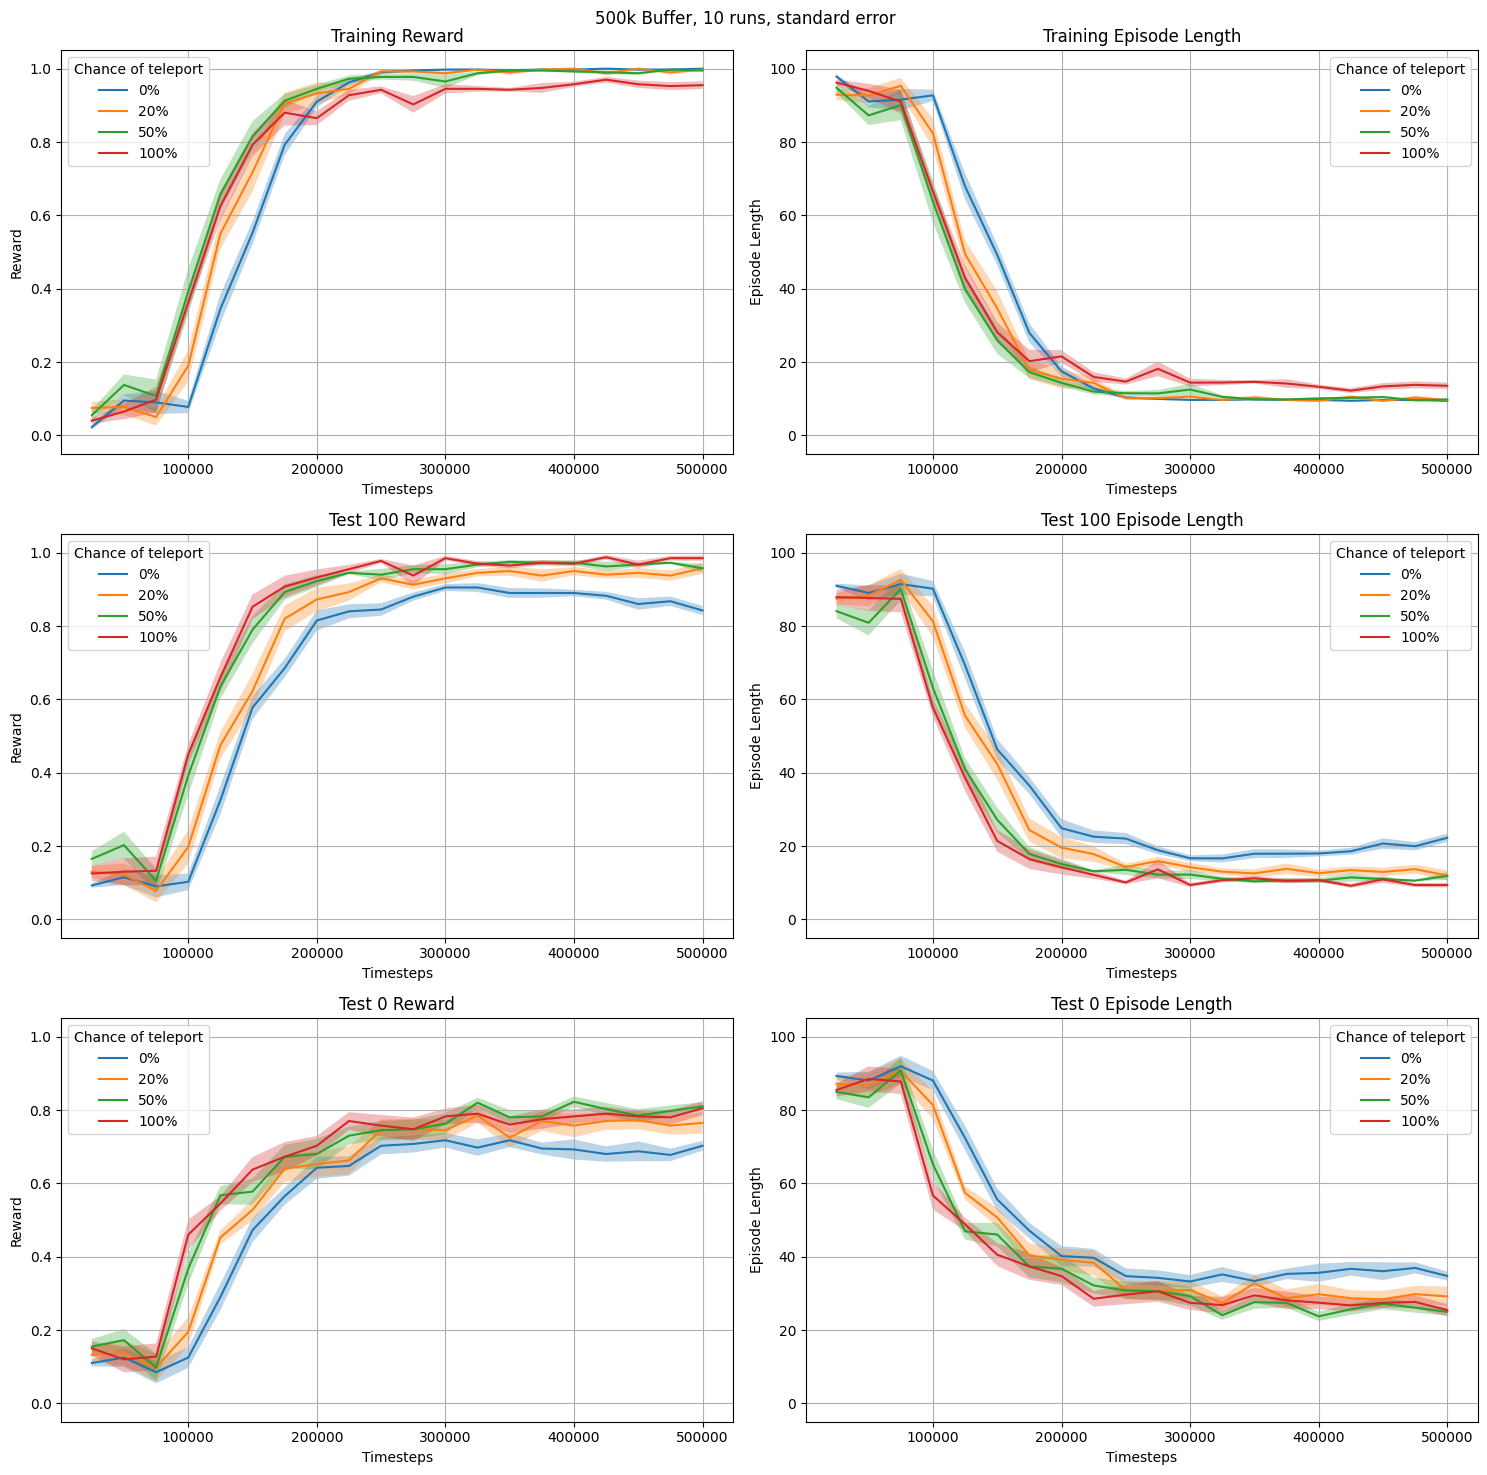

In [1]:
### Visualizing tp chance on exploration 1.0

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=500 #in k
runs=10

base_log=f'./logs/tpchance_b{buffersize}k'

def load_data(env, name):
    tmp=[np.load(f"{base_log}/{name}_{name}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt


cmap=mpl.colormaps['tab10']
colors={}

def plot(ax, dt, title,name, ylabel, ydata, type='std'):
    data=dt[ydata]


    name=f"{round(float(name)*100)}%"

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    if type=='std': #standard deviation
        mean=np.mean(data,axis=0)
        std=np.std(data,axis=0)

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3)
    elif type=='ci': #confidence interval
        mean=np.mean(data,axis=0)
        ci=np.percentile(data,[2.5,97.5],axis=0)

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],ci[0],ci[1],alpha=0.3)
    elif type=='se': #standard error 
        mean=np.mean(data,axis=0)
        se=np.std(data,axis=0)/np.sqrt(data.shape[0])

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Chance of teleport')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,15))

fig.suptitle(f"{buffersize}k Buffer, {runs} runs, standard error")


for name in ['0.0','0.2','0.5','1']:
    results={}
    for env in ['tr', '0', '100']:
        results[env]=load_data(env,name)
    

    plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results')
    plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results')
    plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results')
    plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths')

plt.tight_layout()

/home/felix/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


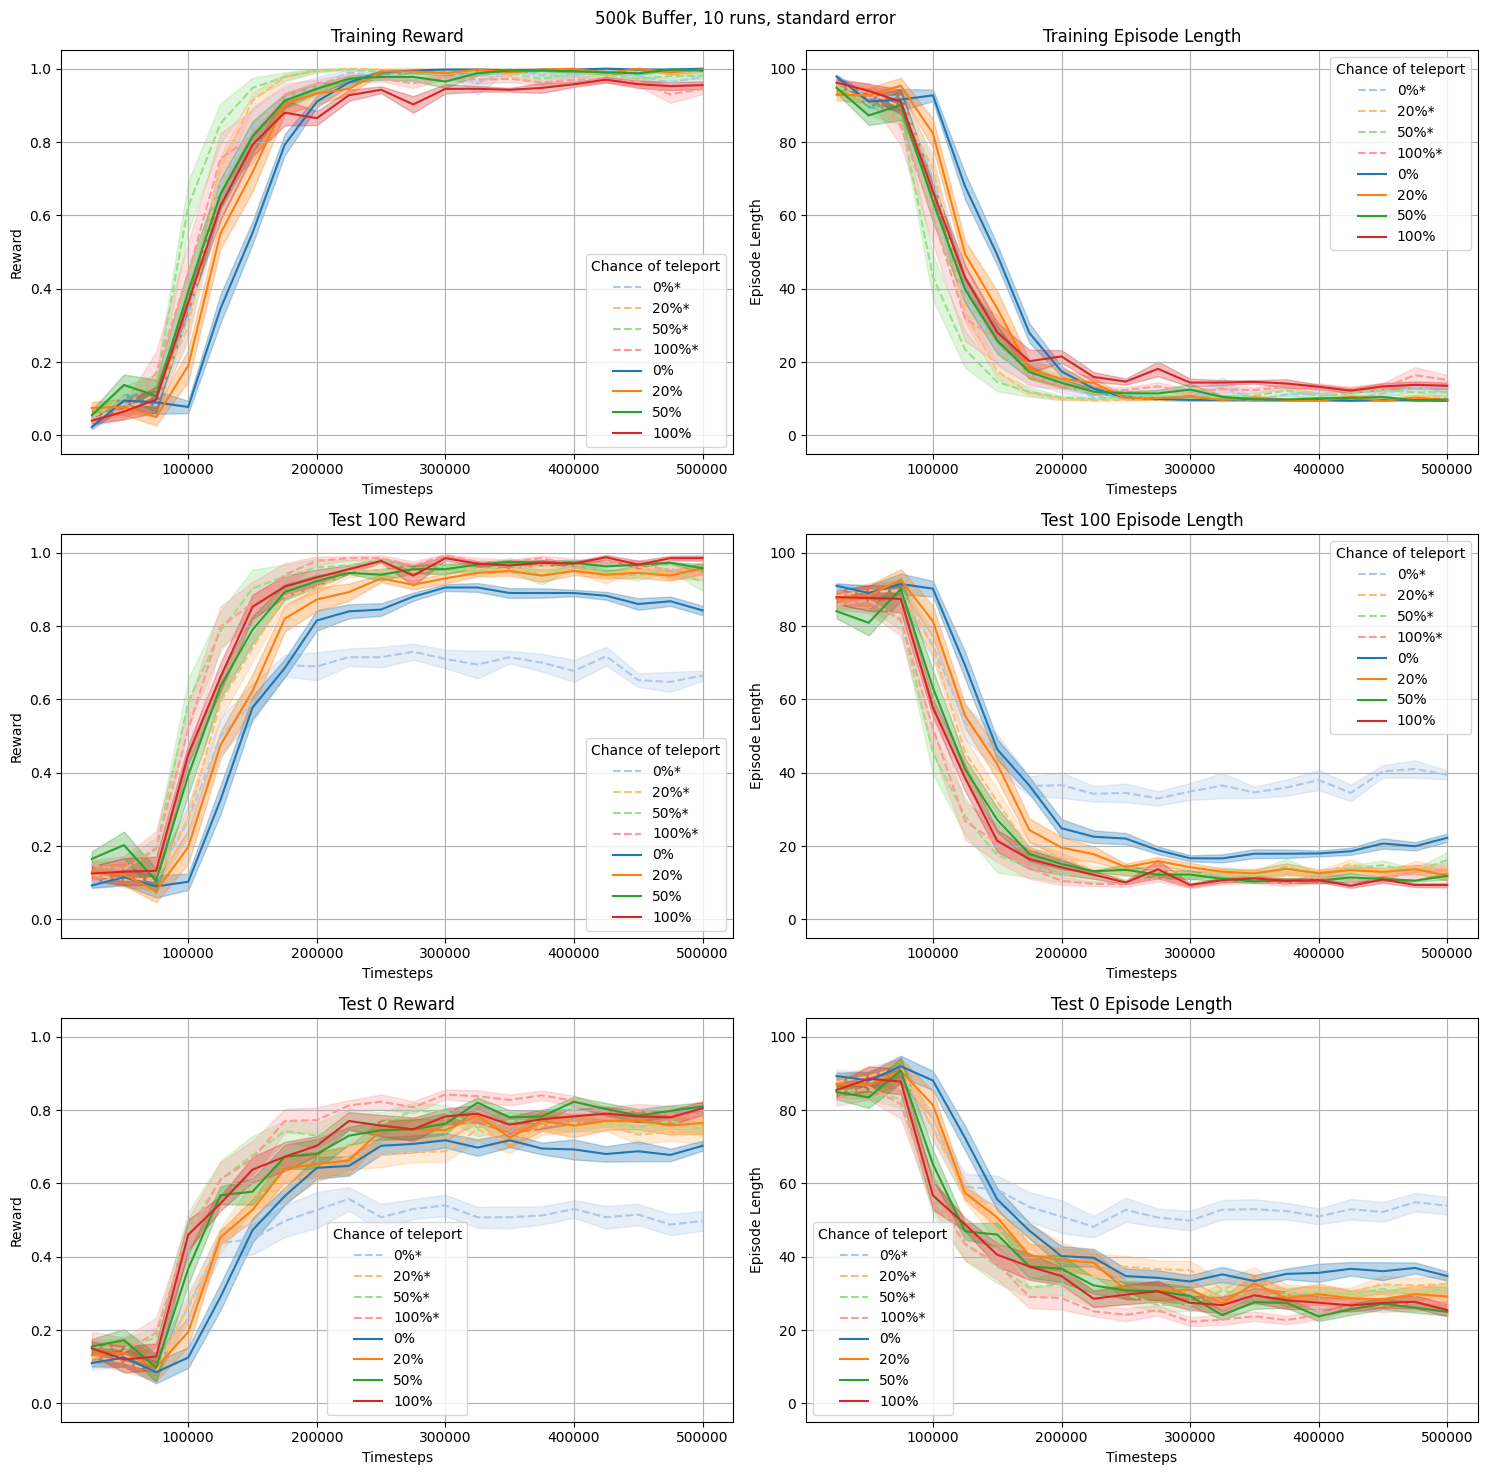

In [1]:
### Visualizing Exploration frac 

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=500 #in k
runs=10

base_log=f'./logs/tpchance_b{buffersize}k'

def load_data(env, name, epsilon=1.0):
    if epsilon==1.0:
        tmp=[np.load(f"{base_log}/{name}_{name}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    else:
        tmp=[np.load(f"{base_log}/{name}_{name}_e0{round(epsilon*10)}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt


cmap=mpl.colormaps['tab20']
colors={}

def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]

    
    if name not in colors:
        colors[name]=len(colors)*2

    color=cmap(colors[name])


    style='-'

    if "dashed" in extra:
        style='--'
        color=cmap(colors[name]+1)


    labe=f"{round(float(name)*100)}%"

    if "suffix" in extra:
        labe+=extra['suffix']

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    if type=='std': #standard deviation
        mean=np.mean(data,axis=0)
        std=np.std(data,axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3, color=color)
    elif type=='ci': #confidence interval
        mean=np.mean(data,axis=0)
        ci=np.percentile(data,[2.5,97.5],axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],ci[0],ci[1],alpha=0.3, color=color)
    elif type=='se': #standard error 
        mean=np.mean(data,axis=0)
        se=np.std(data,axis=0)/np.sqrt(data.shape[0])

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3, color=color)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Chance of teleport')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,15))

fig.suptitle(f"{buffersize}k Buffer, {runs} runs, standard error")

for eps in [0.1,1.0]:
    for name in ['0.0','0.2','0.5','1']:
        results={}
        for env in ['tr', '0', '100']:
            results[env]=load_data(env,name,eps)
        
        extra={}
        if eps==0.1:
            extra['suffix']='*'
            extra['dashed']=True

        plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results', extra=extra)
        plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results', extra=extra)
        plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results', extra=extra)
        plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

plt.tight_layout()

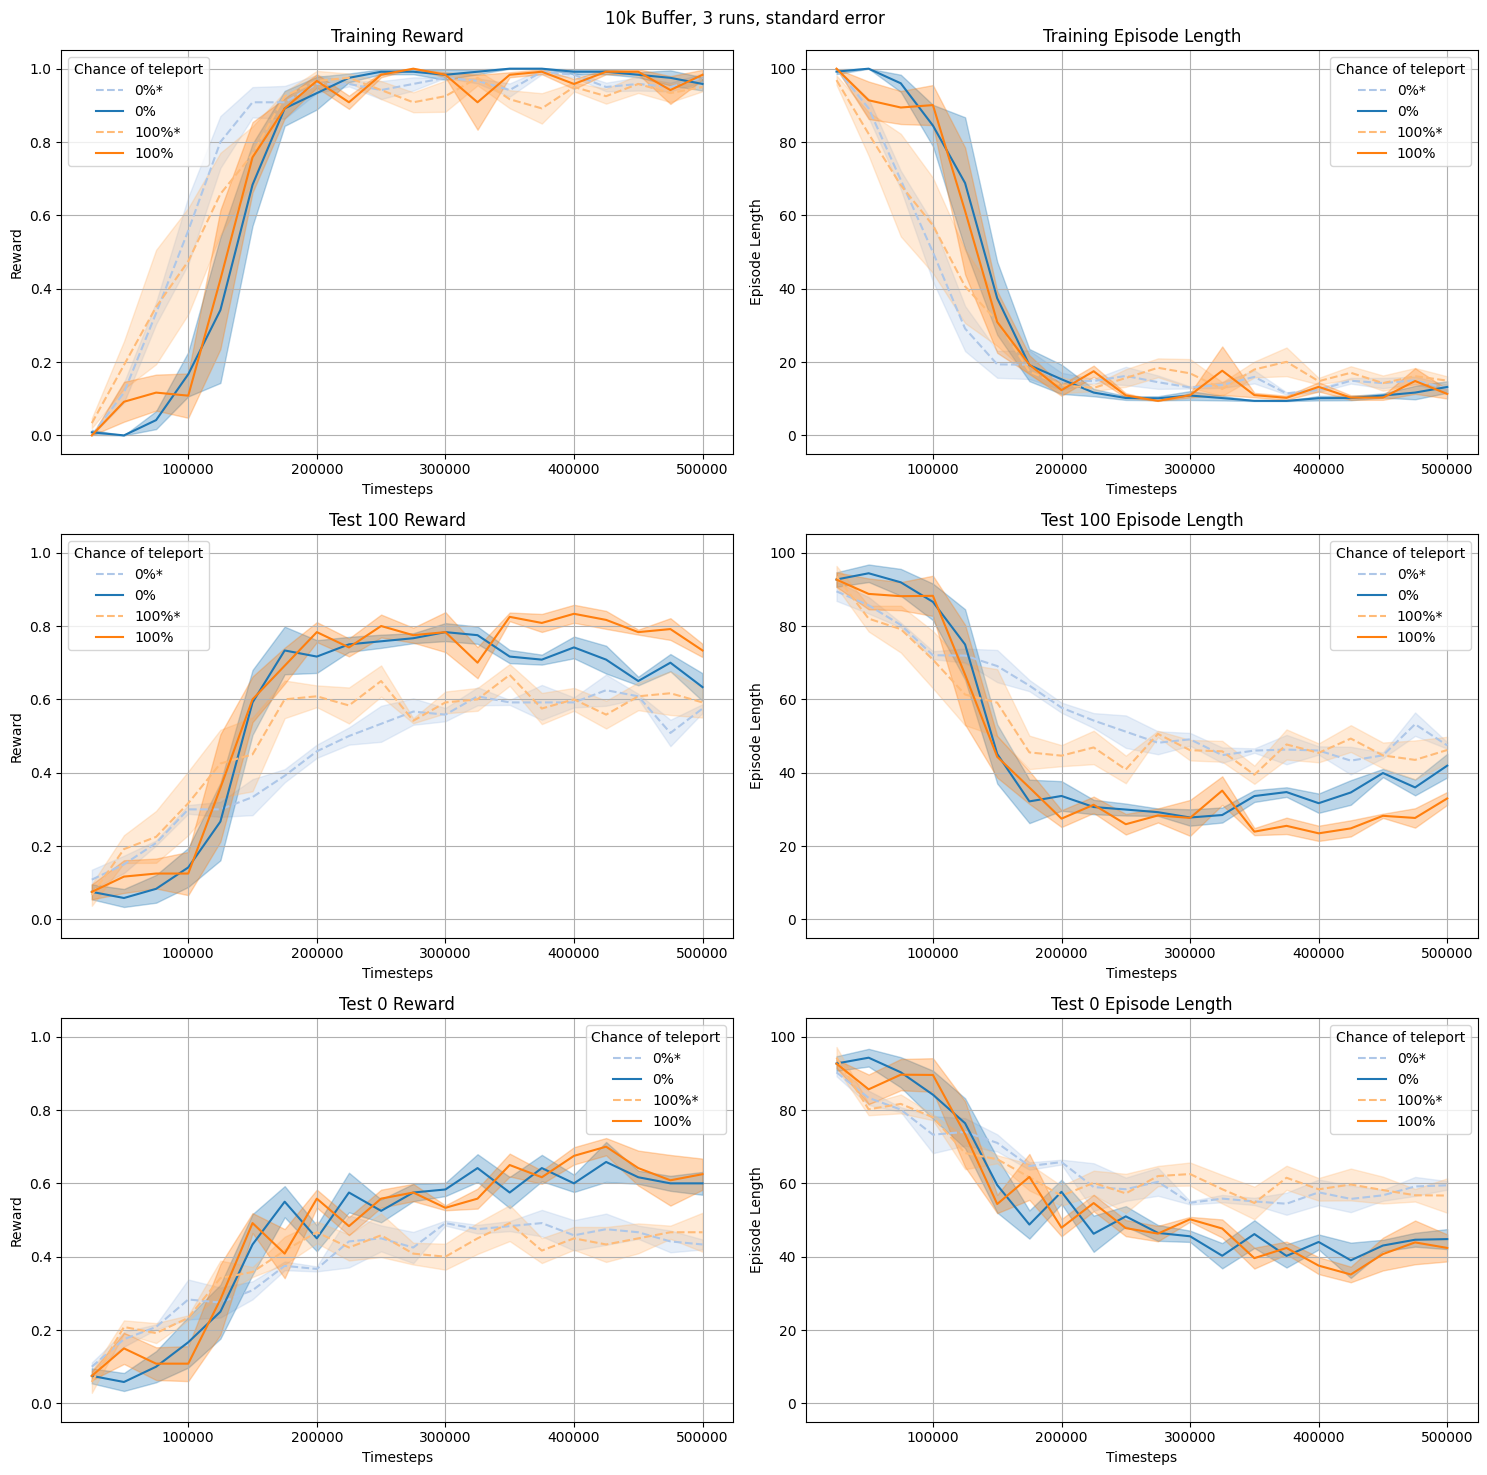

In [9]:
### Visualizing UVF

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=10 #in k
runs=3

base_log=f'./logs/hergo_b{buffersize}k'

def load_data(env, name, epsilon=1.0):
    if epsilon==1.0:
        tmp=[np.load(f"{base_log}/{name}/{env}/{i}/evaluations.npz") for i in range(runs)]
    else:
        tmp=[np.load(f"{base_log}/{name}_e{round(epsilon*100)}/{env}/{i}/evaluations.npz") for i in range(runs)]
    
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt


cmap=mpl.colormaps['tab20']
colors={}

def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]

    
    if name not in colors:
        colors[name]=len(colors)*2

    color=cmap(colors[name])

    style='-'

    if "dashed" in extra:
        style='--'
        color=cmap(colors[name]+1)


    labe=f"{round(float(name)*100)}%"

    if "suffix" in extra:
        labe+=extra['suffix']

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    if type=='std': #standard deviation
        mean=np.mean(data,axis=0)
        std=np.std(data,axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3, color=color)
    elif type=='ci': #confidence interval
        mean=np.mean(data,axis=0)
        ci=np.percentile(data,[2.5,97.5],axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],ci[0],ci[1],alpha=0.3, color=color)
    elif type=='se': #standard error 
        mean=np.mean(data,axis=0)
        se=np.std(data,axis=0)/np.sqrt(data.shape[0])

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3, color=color)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Chance of teleport')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,15))

fig.suptitle(f"{buffersize}k Buffer, {runs} runs, standard error")

for name in ['0.0','1.0']:
    for eps in [0.1,1.0]:
        results={}
        for env in ['tr', '0', '100']:
            results[env]=load_data(env,name,eps)
        
        extra={}

        if eps==0.1:
            extra['suffix']='*'
            extra['dashed']=True

        plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results', extra=extra)
        plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results', extra=extra)
        plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results', extra=extra)
        plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

plt.tight_layout()